In [1]:
import tensorflow as tf
tf.__version__

'2.0.0-rc2'

### dataset API

https://blog.csdn.net/feixiang7701/article/details/81611356

#### dataset 的属性

dataset 可以通过element_spec查看形状和数据dtype

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(0,9))

In [3]:
dataset.element_spec

TensorSpec(shape=(), dtype=tf.int32, name=None)

In [4]:
def test_dataset_conv2d(ds,out_size,last_activation,loss):
    model = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(filters = 6,kernel_size=5,activation="sigmoid"),
        tf.keras.layers.MaxPooling2D(strides = 2),
        tf.keras.layers.Conv2D(filters = 16,kernel_size=5,activation="sigmoid"),
        tf.keras.layers.MaxPooling2D(strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32,activation="sigmoid"),
        tf.keras.layers.Dense(out_size,activation=last_activation)
    ])
    
    model.compile(loss=loss,metrics=["acc"])
    
    model.fit(ds,epochs=3,steps_per_epoch=10)

#### 数据读取
可以通过from_tensor_slices,from_tensors,from_generator

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [6]:
dataset_1 = tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [7]:
def map_fun(x,y):
    x = tf.divide(x,255)
    x = tf.expand_dims(x,axis=-1)
    return x,y

In [8]:
dataset_1 = dataset_1.map(map_func=map_fun).batch(256)

In [9]:
test_dataset_conv2d(dataset_1,10,last_activation="softmax",loss=tf.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 1s 109ms/step - loss: 2.3926 - acc: 0.1066
Epoch 2/3
10/10 [==============================] - 0s 45ms/step - loss: 2.3057 - acc: 0.1191
Epoch 3/3
10/10 [==============================] - 0s 43ms/step - loss: 2.3044 - acc: 0.0980


### 读取Numpy

In [10]:
import numpy as np

In [11]:
DATA_URL = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
path = tf.keras.utils.get_file("mnist.npz",DATA_URL)

In [12]:
with np.load(path) as data:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_test = data["x_test"]
    y_test = data["y_test"]

In [13]:
dataset_2 = tf.data.Dataset.from_tensor_slices((x_train,y_train))

In [14]:
dataset_2 = dataset_2.map(map_func=map_fun)
dataset_2 = dataset_2.batch(256).shuffle(100)

In [15]:
test_dataset_conv2d(dataset_1,10,last_activation="softmax",loss=tf.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 1s 96ms/step - loss: 2.3352 - acc: 0.0996
Epoch 2/3
10/10 [==============================] - 0s 44ms/step - loss: 2.3029 - acc: 0.1148
Epoch 3/3
10/10 [==============================] - 0s 46ms/step - loss: 2.3018 - acc: 0.1008


### Image

In [16]:
DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(fname="flower_photos",origin=DATA_URL,untar=True)

In [17]:
data_dir

'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos'

In [18]:
import pathlib

In [19]:
data_dir = pathlib.Path(data_dir)

In [20]:
dataset_2 = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [21]:
for data in dataset_2.take(2):
    print(data)

tf.Tensor(b'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\tulips\\16309287412_5cc4d58bd1_n.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\tulips\\6970683464_f70838ca3a_n.jpg', shape=(), dtype=string)


#### 构建标签

In [22]:
class_lable =  np.array([ item.name for item in data_dir.glob("*") if item.name != "LICENSE.txt" ])
class_lable

array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'],
      dtype='<U10')

In [23]:
## 转换lable为数值型数据
lable_dic =dict( zip(class_lable,np.asarray(range(0,len(class_lable)))))
lable_dic

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

#### dataset 变换

In [24]:
@tf.function
def get_lable(path):
    parts = tf.strings.split(path,"\\")
    return parts[-2] == class_lable

In [25]:
get_lable(tf.constant("C:\\Users\\Administrator\\.keras\\datasets\\flower_photos\\daisy\\3117644024_1cbb59a509_n.jpg",dtype=tf.string))

<tf.Tensor: id=2186, shape=(5,), dtype=bool, numpy=array([ True, False, False, False, False])>

In [26]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [27]:
def decode_img(img):
    img = tf.image.decode_image(img,channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize_with_crop_or_pad(img,IMG_WIDTH,IMG_HEIGHT)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    return img

In [28]:
def img_map_fun(x):
    lable = get_lable(x)
    img = tf.io.read_file(x)
    img = decode_img(img)
    return img,lable

In [29]:
lable = tf.constant([0,1,2,3,4])
@tf.function
def map_lable_fun(x,y):
    print(y)
    y = lable[y][0]
    return x,y

In [30]:
dataset_2 = dataset_2.map(map_func=img_map_fun,num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(64).repeat()

In [31]:
dataset_2 = dataset_2.map(map_func=map_lable_fun)
dataset_2 = dataset_2.batch(64)

Tensor("y:0", shape=(5,), dtype=bool)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [32]:
image_batch, label_batch = next(iter(dataset_2))

In [33]:
import matplotlib.pyplot as plt

In [34]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_lable[label_batch[n]].title())
        plt.axis('off')

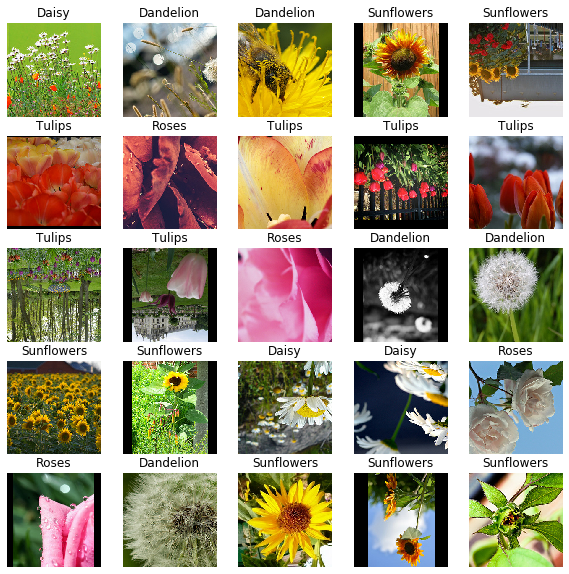

In [35]:
show_batch(image_batch.numpy(),label_batch.numpy())

In [37]:
test_dataset_conv2d(dataset_2,5,"softmax",tf.keras.losses.sparse_categorical_crossentropy)

Train for 10 steps
Epoch 1/3
10/10 [==============================] - 12s 1s/step - loss: 2.2146 - acc: 0.1797
Epoch 2/3
10/10 [==============================] - 11s 1s/step - loss: 1.9843 - acc: 0.2313
Epoch 3/3
10/10 [==============================] - 11s 1s/step - loss: 1.8644 - acc: 0.2375
